# Lesson 5: State analysis
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: MODIS & GPCP**

**Application: greenning and precipitation seasonality**

In state-space theory, a state is an unobserved (latent) variable that evolves through time and governs the dynamics of a system. The observations we collect (e.g., NDVI, reflectance, precipitation) are assumed to be generated from these hidden states, with additional noise. Formally, the basic state-space model is defined by two equations: a state (transition) equation, which describes the temporal evolution of the latent state, and an observation equation, which links the latent state to the observed data. Both equations incorporate stochastic error terms, reflecting uncertainty in the evolving process and the measurement process. This stochastic foundation is the reason why the framework is referred to as stochastic continuous change detection (S-CCD).

$$a_{t}=Ta_{t-1} + Q$$
$$y_{t}=Za_{t} + H$$

   - $a_{t}$: the hidden state at time \(t\)  
   - $T$: transition matrix (defines how states evolve)  
   - $Z$: the system matrix that determines the items included in the observation
   - $y_{t}$: the observation
   - $Q$: process noise
   - $H$: observation noise  

In S-CCD [1], the state is represented as a vector comprising three temporal components: trend, annual, and semiannual. When `trimodel`=True is specified in the flexible mode, an additional component corresponding to a four-month cycle (`trimodel`) is included. S-CCD supports the output of states for each of these components. Unlike the harmonic regression line with fixed coefficients, the states incorporate both observational and process noise, resulting in temporal variability that better captures local fluctuations.

This lesson demonstrates a novel application of `states` for analyzing subtle long-term changes that are often overlooked by traditional break detection approaches.

*[1] Ye, S., Rogan, J., Zhu, Z., & Eastman, J. R. (2021). A near-real-time approach for monitoring forest disturbance using Landsat time series: Stochastic continuous change detection. Remote Sensing of Environment, 252, 112167.*

---
## Greenness trend in Tibet (MODIS)

In [1]:
import pandas as pd
import numpy as np
import pathlib
from dateutil import parser
from pyxccd import sccd_detect_flex

TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()

in_path = TUTORIAL_DATASET/ '5_greenning_modis.csv' # read single-pixel MODIS time series


# read example csv for HLS time series
data = pd.read_csv(in_path)

# as the original data doesn't have qa, we append qa as all zeros value (meaning they are all clear)
data['qa'] = np.zeros(data.shape[0])

# force column name to 'date' to let display_sccd_states work
data = data.rename(columns={'date': 'dates'})

# convert them to ordinal dates
ordinal_dates = [pd.Timestamp.toordinal(parser.parse(row)) for row in data["dates"]]
data.loc[:, "dates"] = ordinal_dates

dates, ndvi, qas = data.to_numpy().copy().T
print(sccd_detect_flex(dates, ndvi, qas, lam=20, state_intervaldays=1))

ValueError: Expected int16, int32, int64 for the input, but got object

Oops, we got the error "Expected int16, int32, int64 for the input, but got object". This is because is that the datatype for NDVI is double [-1, 1]. We need to convert it to integer. **Pyxccd only supports integer input!**

The scale does change the results of CCDC because the Lasso parameter is sensitive to the magnitude of the input values, which directly influences the balance between fitting accuracy and regularization strength. To ensure optimal performance and comparability, we recommend scaling the floating-point reflectance values so that they fall within or close to the standard Landsat reflectance range [0,10000]. This adjustment harmonizes the input data with the scale for which CCDC is typically calibrated and helps prevent bias in model fitting. In this case, multiplying the reflectance values by 10,000 provides an appropriate transformation:

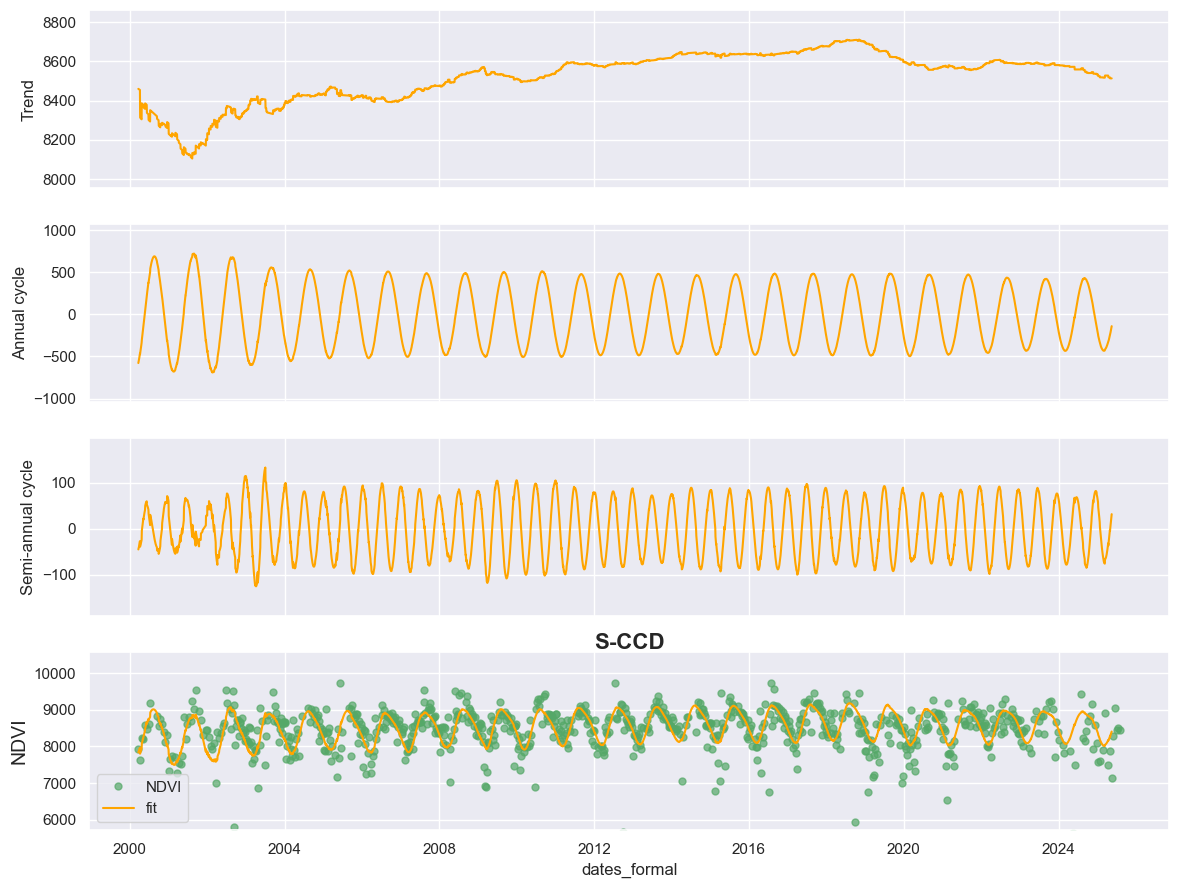

In [2]:
import pathlib
from datetime import date
from typing import List, Tuple, Dict, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from pyxccd.common import SccdOutput
from pyxccd.utils import getcategory_sccd, defaults

def display_sccd_states_flex(
    data_df: pd.DataFrame,
    states:pd.DataFrame,
    axes: Axes,
    variable_name: str,
    title:str,
    band_name:str = "b0",
    plot_kwargs: Optional[Dict] = None
):
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # convert ordinal dates to calendar
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
    states.loc[:, "dates_formal"] = formal_dates  

    extra = (np.max(states[f"{band_name}_trend"]) - np.min(states[f"{band_name}_trend"])) / 4
    axes[0].set(ylim=(np.min(states[f"{band_name}_trend"]) - extra, np.max(states[f"{band_name}_trend"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_trend", data=states, ax=axes[0], color="orange")
    axes[0].set(ylabel=f"Trend")

    extra = (np.max(states[f"{band_name}_annual"]) - np.min(states[f"{band_name}_annual"])) / 4
    axes[1].set(ylim=(np.min(states[f"{band_name}_annual"]) - extra, np.max(states[f"{band_name}_annual"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_annual", data=states, ax=axes[1], color="orange")
    axes[1].set(ylabel=f"Annual cycle")

    extra = (np.max(states[f"{band_name}_semiannual"]) - np.min(states[f"{band_name}_semiannual"])) / 4
    axes[2].set(ylim=(np.min(states[f"{band_name}_semiannual"]) - extra, np.max(states[f"{band_name}_semiannual"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_semiannual", data=states, ax=axes[2], color="orange")
    axes[2].set(ylabel=f"Semi-annual cycle")


    data_clean = data_df[(data_df["qa"] == 0) | (data_df['qa'] == 1)].copy() # CCDC also processes water pixels
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, "dates_formal"] = formal_dates  # convert ordinal dates to calendar
    axes[3].plot(
        'dates_formal', variable_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    if f"{band_name}_trimodal" in list(states.columns):
        states["General"] = states[f"{band_name}_annual"] + states[f"{band_name}_trend"] + states[f"{band_name}_semiannual"]+ states[f"{band_name}_trimodal"]
    else:
        states["General"] = states[f"{band_name}_annual"] + states[f"{band_name}_trend"] + states[f"{band_name}_semiannual"]
    g = sns.lineplot(
        x="dates_formal", y="General", data=states, label="fit", ax=axes[3], color="orange"
    )
            
    axes[3].set_ylabel(f"{variable_name}", fontsize=default_plot_kwargs['font_size'])
    axes[3].set_title(title, fontweight="bold", size=16 , pad=2)
    
    band_values = data_df[data_df['qa'] == 0][variable_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra
    axes[3].set(ylim=(ylim_low, ylim_high))



data_copy = data.copy()

# Multiplying NDVI by 10000
data_copy.NDVI = data_copy.NDVI.multiply(10000)
dates, ndvi,  qas = data_copy.to_numpy().astype(np.int64).copy().T

# Turn on the state output by setting state_intervaldays as non-zero value
sccd_results, states = sccd_detect_flex(dates, ndvi, qas, lam=20, state_intervaldays=1)

# Set up plotting style
sns.set(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=[12, 10], sharex=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

display_sccd_states_flex(data_df=data_copy,  states=states, axes=axes, variable_name="NDVI", title="S-CCD")


Multiple studies revealed that our earth has experienced a slowdown of the vegetation greening [2, 3]. We also visually confirm the same slowdown trend from `Trend` component. 

*[2] Feng, X., Fu, B., Zhang, Y., Pan, N., Zeng, Z., Tian, H., ... & Penuelas, J. (2021). Recent leveling off of vegetation greenness and primary production reveals the increasing soil water limitations on the greening Earth. Science Bulletin, 66(14), 1462-1471.*

*[3] Ren, Y., Wang, H., Yang, K., Li, W., Hu, Z., Ma, Y., & Qiao, S. (2024). Vegetation productivity slowdown on the Tibetan Plateau around the late 1990s. Geophysical Research Letters, 51(4), e2023GL103865.*

### Finding the turning point
I will use `kneed` package to automatically locate the timepoint that the slowdown trend starts for this MODIS pixel.  The `kneed` package found the the `knee` of a curve based upon the maximum curvature where a curve changes from a steep slope to a flatter one.

The knee date (i.e., when NDVI saturates) is 2005-03-06 00:00:00
The knee NDVI  is 0.8471548930431367


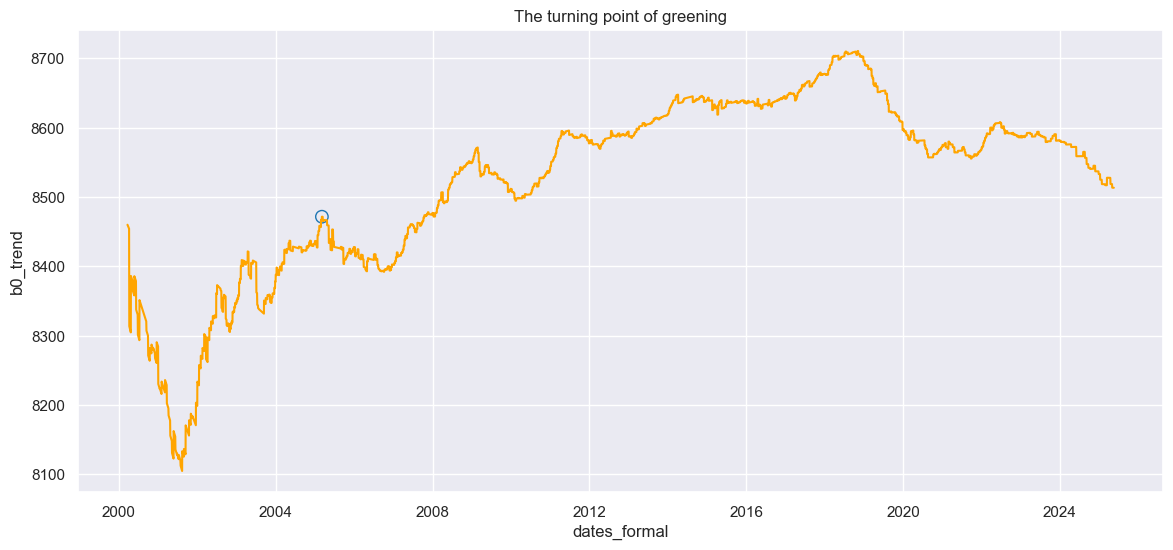

In [3]:
from kneed import KneeLocator

# find the minimum NDVI trend value
istart = np.where(states['b0_trend'].to_numpy()==np.min(states['b0_trend'].to_numpy()))[0][0]

# Detecting the knee between the minimum NDVI to the maximum
knee = KneeLocator(states['dates'].to_numpy()[istart:], states['b0_trend'].to_numpy()[istart:],  direction="increasing")
xknee = states['dates'].to_numpy()[istart:][np.argmax(knee.y_difference)]
yknee = states['b0_trend'].to_numpy()[istart:][np.argmax(knee.y_difference)]

sns.set(style="darkgrid")
sns.set_context("notebook")

fig, ax = plt.subplots(figsize=(14, 6))


formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
states.loc[:, "dates_formal"] = formal_dates  
sns.lineplot(data=states, ax=ax, x='dates_formal', y='b0_trend', legend=False, color='orange', palette='colorblind').set_title("The turning point of greening")

ax.scatter(pd.Timestamp.fromordinal(int(xknee)), yknee , s=80, marker='o', facecolors='none', edgecolors='#1f77b4')

print(f"The knee date (i.e., when NDVI saturates) is {pd.Timestamp.fromordinal(int(xknee))}")
print(f"The knee NDVI  is {yknee/10000}")

### Summary 1

S-CCD provides an innovative framework for **decomposing satellite-based time series into multiple interpretable components** while explicitly accounting for temporal breaks. By separating the signal into trend, and seasonal components, S-CCD enables a clearer understanding of ecosystem dynamics under various disturbance and recovery regimes. The extracted trend component is particularly informative, as it can reveal subtle or gradual shifts in vegetation or biophysical conditions that are often masked by strong seasonal fluctuations or short-term noise. Such long-term trend changes frequently originate from external drivers such as climatic variability, human activities, or natural disturbances. By effectively suppressing seasonal and irregular variations, S-CCD enhances the detectability of these underlying changes, offering a more robust and interpretable view of ecosystem trajectories over time.


## Precipitation seasonality

The seasonality amplitude of the annual precipitation cycle refers to the strength of the seasonal contrast. It has been reported that the seasonality amplitude is being amplified as global warming [4]. indicating a greater difference between the wettest and driest periods. But this trend might be regional, requiring careful examination. 

*[4] Wang, X., Luo, M., Song, F., Wu, S., Chen, Y. D., & Zhang, W. (2024). Precipitation seasonality amplifies as earth warms. Geophysical Research Letters, 51(10), e2024GL109132.*

The below is an example that we will evaluate this trend for a pixel in Arctic. Let's quickly plot the time series for the first step:

Text(0.5, 0, 'Date')

<Figure size 640x480 with 0 Axes>

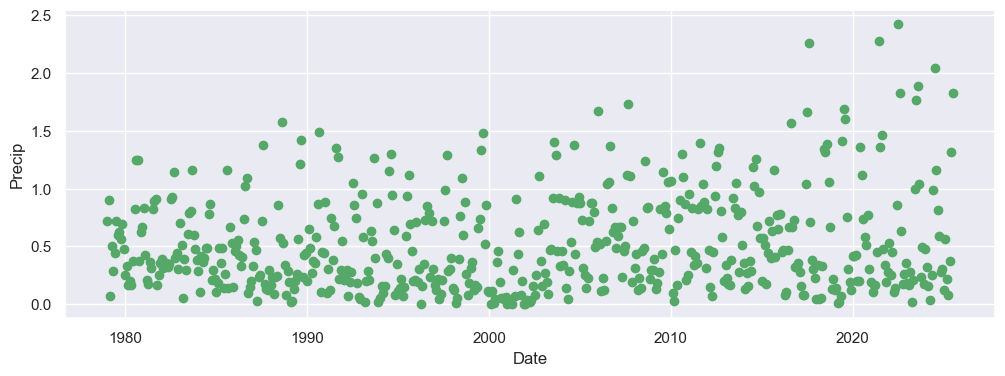

In [10]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '5_precip_gpcp.csv' # read the MPB-affected plot in CO

# read example csv for HLS time series
data = pd.read_csv(in_path)

# as the original data doesn't have qa, we append qa as all zeros value (meaning they are all clear)
data['qa'] = np.zeros(data.shape[0])

formal_dates = [parser.parse(row) for row in data["time"]]
data.loc[:, "dates_formal"] = formal_dates  

# convert formal to ordinaldates
ordinal_dates = [pd.Timestamp.toordinal(parser.parse(row)) for row in data["time"]]
data.loc[:, "time"] = ordinal_dates

fig, axes = plt.subplots(figsize=[12, 4])
axes.plot(
    'dates_formal', "precip", 'go',
    data=data
)
plt.ylabel("Precip")
plt.xlabel("Date")


From the above example, we did see the amplitude of the precipitation seasonality increased since 2019-ish. In most of the high Arctic, precipitation peaks in summer (largely as rain, due to open water and more active moisture transport). Warming oceans and reduced sea ice increase moisture flux into the atmosphere, enhancing summer precipitation (especially rainfall), increasing the amplitude of the seasonality. Let's use S-CCD states to investigate the increasing amplitude.

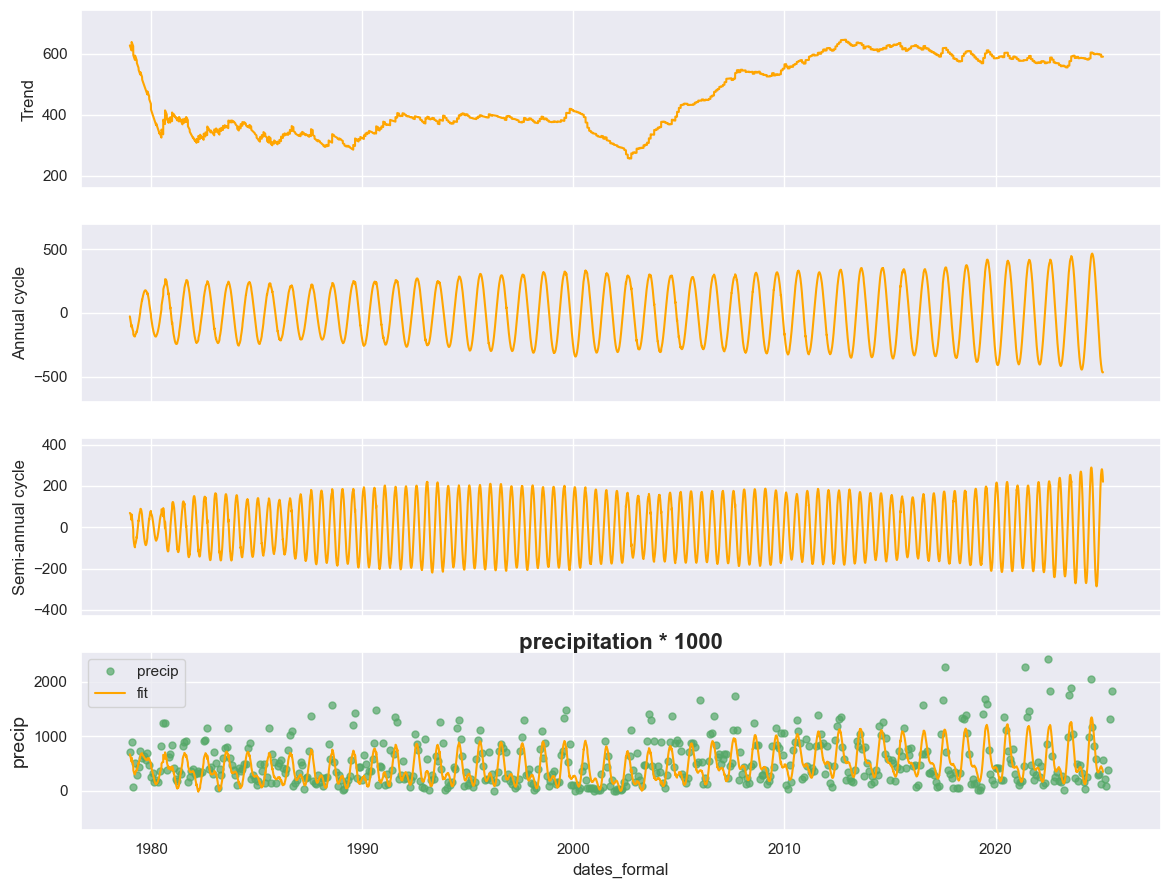

In [5]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=[12, 10], sharex=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

# read example csv for HLS time series
TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '5_precip_gpcp.csv' # read the MPB-affected plot in CO
data = pd.read_csv(in_path)

# as the original data doesn't have qa, we append qa as all zeros value (meaning they are all clear)
data['qa'] = np.zeros(data.shape[0])

formal_dates = [parser.parse(row) for row in data["time"]]
data.loc[:, "dates_formal"] = formal_dates  

# convert formal to ordinaldates
ordinal_dates = [pd.Timestamp.toordinal(parser.parse(row)) for row in data["time"]]
data.loc[:, "time"] = ordinal_dates

# scale precipitation by 1000
data.loc[:, "precip"] = data.loc[:, "precip"].apply(lambda x: x*1000)

# force column name to 'date' to let display_sccd_states work
data = data.rename(columns={'time': 'dates'})

dates, prep, qas = data.drop('dates_formal', axis=1).astype(np.int32).to_numpy().copy().T
sccd_result, states = sccd_detect_flex(dates, prep, qas, lam=20, state_intervaldays=1)
display_sccd_states_flex(data_df=data, states=states, axes=axes, variable_name="precip", title="precipitation * 1000")

Unfortunately, we only observed a subtle increase in the amplitude of the semi-annual cycle toward the end of the time series. Further investigation can reveal that this pattern resulted from under-fitting of extreme summer precipitation events, which led to the failure in capturing the enhanced seasonality signal. To improve the S-CCD fitting for this dataset, we decreased the Lambda to 0:

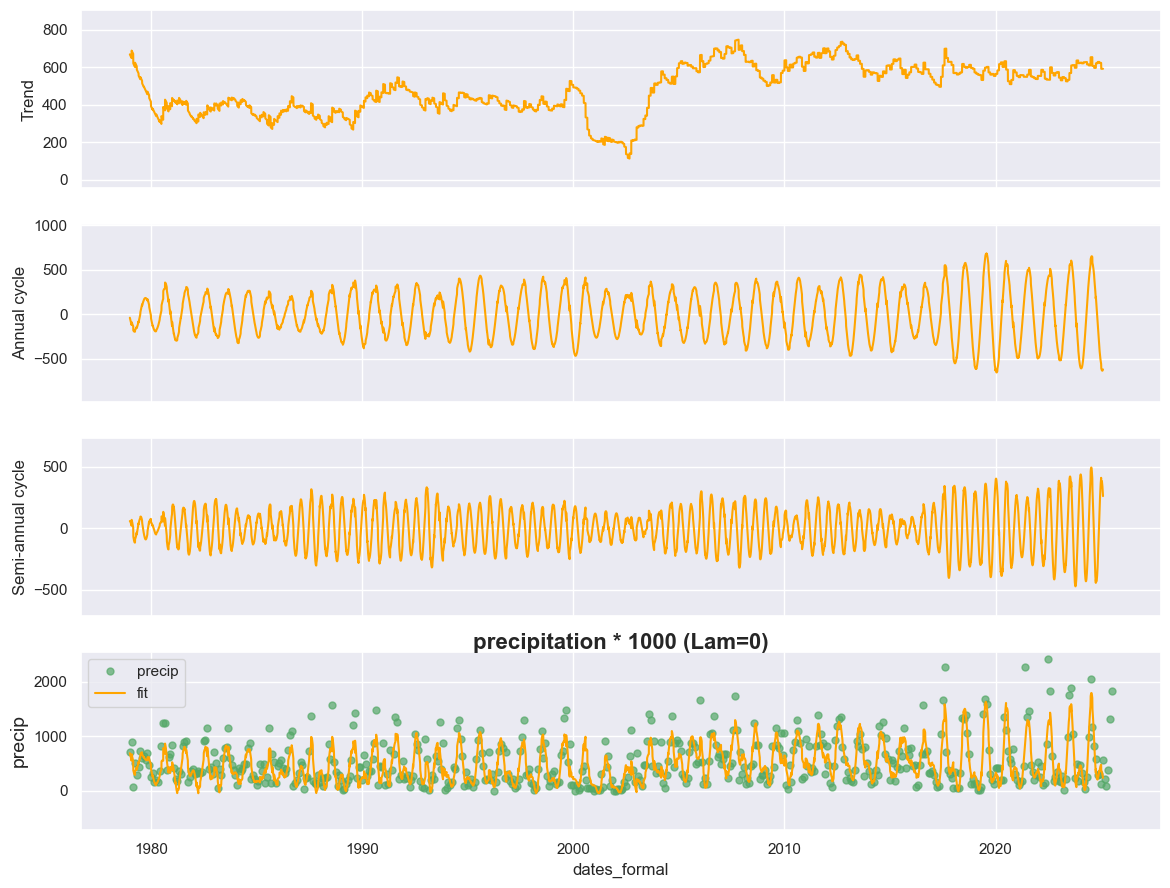

In [6]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=[12, 10], sharex=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

# decrease lambda to 0
sccd_result, states = sccd_detect_flex(dates, prep, qas, lam=0, state_intervaldays=1)
display_sccd_states_flex(data_df=data, states=states, axes=axes, variable_name="precip", title="precipitation * 1000 (Lam=0)")

Now, after reaching a better model fit, you could see the increased seasonality amplitude has been captured in both annual (the second subfigure) and semi-annual (the third subfigure) cycle components through enhancing the fitting degree of the curve for the observations. 

We could sum up annual and semi-annual into a new component for the general seasonal cycle for a better investigation:

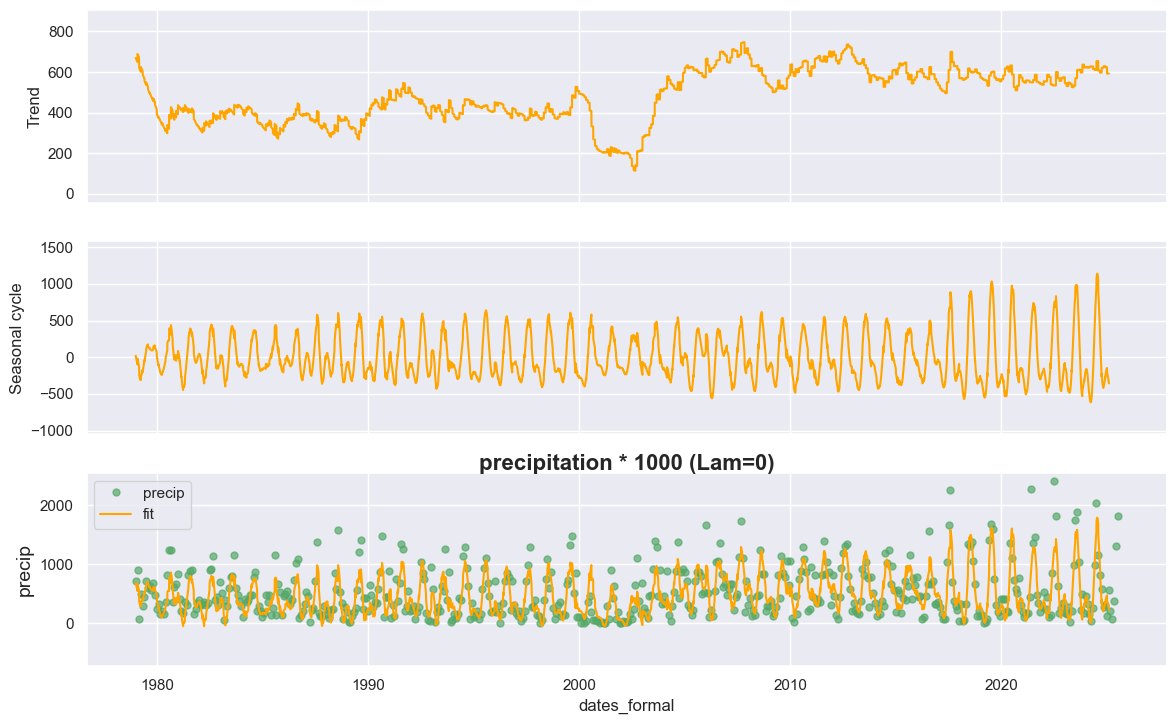

In [7]:
def display_sccd_states_flex_adjusted(
    data_df: pd.DataFrame,
    states:pd.DataFrame,
    axes: Axes,
    variable_name: str,
    title:str,
    band_name:str = "b0",
    plot_kwargs: Optional[Dict] = None
):
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # convert ordinal dates to calendar
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
    states.loc[:, "dates_formal"] = formal_dates  

    extra = (np.max(states[f"{band_name}_trend"]) - np.min(states[f"{band_name}_trend"])) / 4
    axes[0].set(ylim=(np.min(states[f"{band_name}_trend"]) - extra, np.max(states[f"{band_name}_trend"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_trend", data=states, ax=axes[0], color="orange")
    axes[0].set(ylabel=f"Trend")

    extra = (np.max(states[f"{band_name}_seasonality"]) - np.min(states[f"{band_name}_seasonality"])) / 4
    axes[1].set(ylim=(np.min(states[f"{band_name}_seasonality"]) - extra, np.max(states[f"{band_name}_seasonality"]) + extra))
    sns.lineplot(x="dates_formal", y=f"{band_name}_seasonality", data=states, ax=axes[1], color="orange")
    axes[1].set(ylabel=f"Seasonal cycle")



    data_clean = data_df[(data_df["qa"] == 0) | (data_df['qa'] == 1)].copy() # CCDC also processes water pixels
    formal_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, "dates_formal"] = formal_dates  # convert ordinal dates to calendar
    axes[2].plot(
        'dates_formal', variable_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    if f"{band_name}_trimodal" in list(states.columns):
        states["General"] = states[f"{band_name}_annual"] + states[f"{band_name}_trend"] + states[f"{band_name}_semiannual"]+ states[f"{band_name}_trimodal"]
    else:
        states["General"] = states[f"{band_name}_annual"] + states[f"{band_name}_trend"] + states[f"{band_name}_semiannual"]
    g = sns.lineplot(
        x="dates_formal", y="General", data=states, label="fit", ax=axes[2], color="orange"
    )
            
    axes[2].set_ylabel(f"{variable_name}", fontsize=default_plot_kwargs['font_size'])
    axes[2].set_title(title, fontweight="bold", size=16 , pad=2)
    
    band_values = data_df[data_df['qa'] == 0][variable_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra
    axes[2].set(ylim=(ylim_low, ylim_high))


fig, axes = plt.subplots(3, 1, figsize=[12, 8], sharex=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)
sccd_result, states = sccd_detect_flex(dates, prep, qas, lam=0, state_intervaldays=1)

# sum up two components
states['b0_seasonality'] = states['b0_annual'] + states['b0_semiannual']

display_sccd_states_flex_adjusted(data_df=data, states=states, axes=axes, variable_name="precip", title="precipitation * 1000 (Lam=0)")

### Summary 2
Further quantification of seasonality amplitude can be achieved by calculating the difference between the maximum and minimum values of the “Seasonal cycle” variable derived from the above steps. This approach provides a more stable estimate of intra-annual variability compared with directly differencing the maximum and minimum of the raw observations. The key advantage lies in the fact that S-CCD incorporates a Kalman filter during the fitting process, which effectively smooths the time series and reduces the influence of noise, outliers, and irregular sampling. As a result, the estimated amplitude better reflects the underlying seasonal signal rather than being distorted by anomalous measurements.

## S-CCD model fit

S-CCD provides three approaches for model fitting:
(1) directly summing all state components;
(2) applying LASSO regression using all observations within a segment (`fitting_coefs=True`); and
(3) adopting time-specific harmonic model coefficients estimated at the last model through the Kalman filter (`fitting_coefs=False`).

In general, summing all states (the first approach) offers the most effective means of capturing local fluctuations in the time series and therefore yields the lowest RMSE. Applying LASSO regression (the second approach) corresponds to the coefficient-generation strategy used in the traditional CCDC algorithm and provides the best generalization capability, as it outputs only eight coefficients that can serve as shape parameters for machine learning inputs. Using time-specific harmonic model coefficients (the third approach) reflects model behavior only at the most recent observations and may lead to underfitting for earlier portions of the time series. This approach is particularly suitable for near-real-time monitoring applications, where the primary focus is on detecting and characterizing recent disturbances.

The below are the examples for fitting comparison using the precipitation datasets:

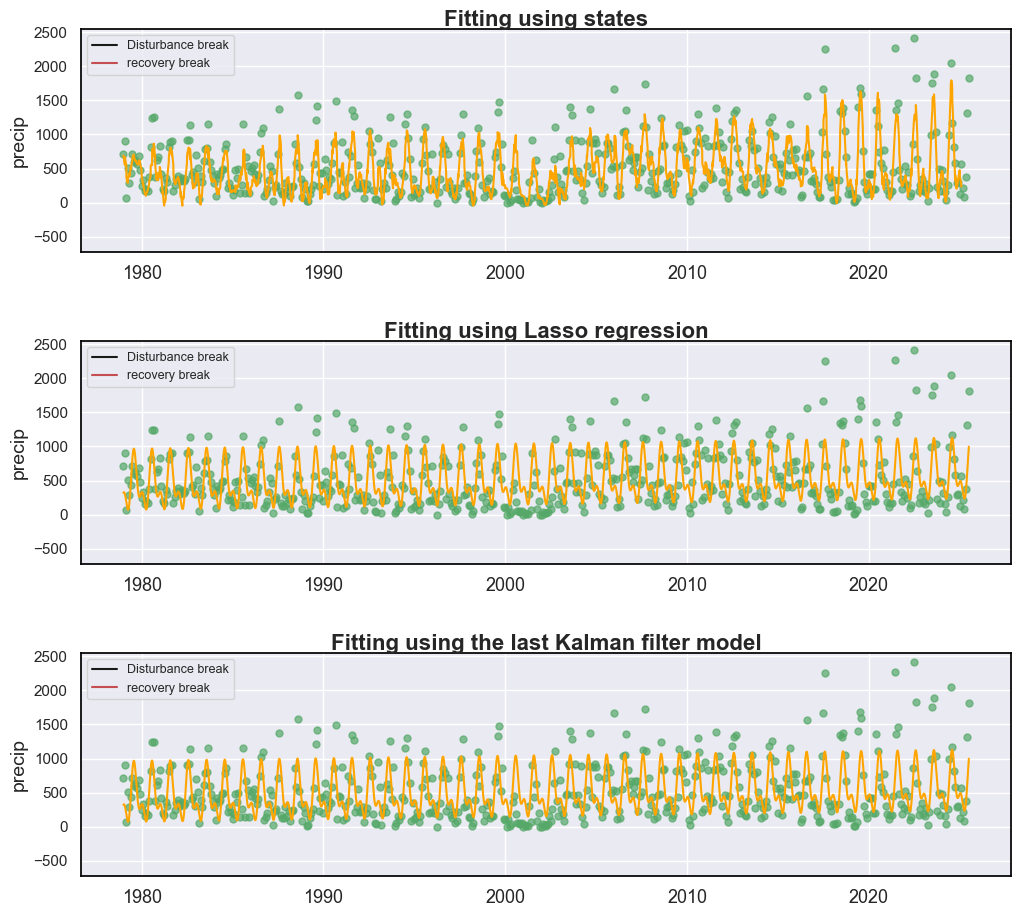

In [9]:
from pyxccd.common import SccdOutput, cold_rec_cg, anomaly
from matplotlib.lines import Line2D

def display_sccd_result_single(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    states:Optional[pd.DataFrame] = None,
    trimodal: bool = False,
    anomaly:Optional[anomaly] = None,
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
        
    trimodal: bool
        indicate whether using trimodal
    
    anomaly: anomaly, optional
        The anomaly detection outputs
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    if trimodal:
        n_coefs = 8
    else:
        n_coefs = 6
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    if states is not None:
        if trimodal is True:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']+states['b0_trimodal']
        else:
            states['predicted'] = states['b0_trend']+states['b0_annual']+states['b0_semiannual']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in states["dates"]]
        states.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=states,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()
    else:
        for segment in sccd_result.rec_cg:
            j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': j * 0
                })

            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                    'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
                })
                

            # Convert dates and plot model fit
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()

        # Plot near-real-time projection for SCCD if available
        if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
            recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
            j = np.arange(
                sccd_result.nrt_model['t_start_since1982'].item() + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
                recent_obs[-1].item()+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
                1
            )

            if trimodal == True:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
                })
            else:
                plot_df = pd.DataFrame(
                    {
                    'dates': j,
                    'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                    'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                    'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                    'trimodal': j * 0
                })
                
            plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
            calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
            plot_df.loc[:, 'dates_formal'] = calendar_dates
            g = sns.lineplot(
                x="dates_formal", y="predicted",
                data=plot_df,
                label="Model fit",
                ax=axe,
                color=default_plot_kwargs['line_color']
            )
            if g.legend_ is not None: 
                g.legend_.remove()
            
    # add manual legends
    if anomaly is not None:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                            Line2D([0], [0], label='recovery break', color='r'),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="black",
                            label='Disturbance anomalies', lw=0, markersize=8),
                            Line2D([0], [0], marker='o', color="#EAEAF2",
                            markerfacecolor="#EAEAF2",markeredgecolor="red",
                            label='Recovery anomalies', lw=0, markersize=8)]
    else:
        legend_elements = [Line2D([0], [0], label='Disturbance break', color='k'),
                    Line2D([0], [0], label='recovery break', color='r')]
    axe.legend(handles=legend_elements, loc='upper left', prop={'size': 9})
    
    # plot breaks
    for i in range(len(sccd_result.rec_cg)):
        # we used the sign of change magnitude to decide the category of the breaks
        if sccd_result.rec_cg[i]['magnitude'] < 0:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
   
    
    # plot anomalies if available
    if anomaly is not None:
        for i in range(len(anomaly.rec_cg_anomaly)):
            pred_ref = np.asarray(
                    [
                        predict_ref(
                            anomaly.rec_cg_anomaly[i]["coefs"][0],
                            anomaly.rec_cg_anomaly[i]["obs_date_since1982"][i_conse]
                            + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], num_coefficients=n_coefs
                        ) for i_conse in range(3)
                    ]
            )

            cm = anomaly.rec_cg_anomaly[i]["obs"][0, 0: 3] - pred_ref
            
            # gpp increase is black line
            if np.median(cm) > 0:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ro',fillstyle='none',markersize=8)         
            # gpp decrease is red line
            else:
                yc = data[data[:,0] == anomaly.rec_cg_anomaly[i]['t_break']][0][1]
                axe.plot(pd.Timestamp.fromordinal(anomaly.rec_cg_anomaly[i]['t_break']), yc,'ko',fillstyle='none',markersize=8) 
        
    axe.set_ylabel(f"{band_name}", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)

fig, axes = plt.subplots(3, 1, figsize=(12, 11))
plt.subplots_adjust(hspace=0.4)

# fitting using the state output
sccd_result1, states = sccd_detect_flex(dates, prep, qas, lam=0, state_intervaldays=1)
display_sccd_result_single(data=data[['dates', 'precip', 'qa']].to_numpy().astype(np.int64), band_names=['precip'], band_index=0, sccd_result=sccd_result1, axe=axes[0], trimodal=False, states=states, title=f"Fitting using states")

# fitting using lasso regression
sccd_result2= sccd_detect_flex(dates, prep, qas, lam=0, fitting_coefs=True)
display_sccd_result_single(data=data[['dates', 'precip', 'qa']].to_numpy().astype(np.int64), band_names=['precip'], band_index=0, sccd_result=sccd_result2, axe=axes[1], trimodal=False, title=f"Fitting using Lasso regression")

# fitting using the last model cofficients from Kalman filter
sccd_result3= sccd_detect_flex(dates, prep, qas, lam=0, fitting_coefs=False)
display_sccd_result_single(data=data[['dates', 'precip', 'qa']].to_numpy().astype(np.int64), band_names=['precip'], band_index=0, sccd_result=sccd_result2, axe=axes[2], trimodal=False, title=f"Fitting using the last Kalman filter model")
